In [1]:
# %% [markdown]
# # Tableau de bord d'analyse des données de santé
# 
# ## Analyse de la qualité et profilage des données

# %%
import sys
sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.quality_analysis import DataQualityAnalyzer
from scripts.data_profiling import DataProfiler


In [2]:

# Configuration des visualisations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# %%
# Initialisation des analyseurs
quality_analyzer = DataQualityAnalyzer()
profiler = DataProfiler()


In [3]:

# %%
# 1. RAPPORT DE QUALITÉ
print("="*80)
print("RAPPORT DE QUALITÉ DES DONNÉES")
print("="*80)

report = quality_analyzer.generate_quality_report()

print("\n▶ Complétude des données:")
display(report['completeness'])

print("\n▶ Cohérence des données:")
display(report['consistency'])

print("\n▶ Fraîcheur des données:")
display(report['freshness'])


RAPPORT DE QUALITÉ DES DONNÉES

▶ Complétude des données:


c:\Users\roosv\Desktop\Pro\AI_in_HealthCare_Dataset\notebooks\..\scripts\quality_analysis.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, self.conn)
c:\Users\roosv\Desktop\Pro\AI_in_HealthCare_Dataset\notebooks\..\scripts\quality_analysis.py:93: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, self.conn)
c:\Users\roosv\Desktop\Pro\AI_in_HealthCare_Dataset\notebooks\..\scripts\quality_analysis.py:121: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query,

,total_records,age_completeness_pct,gender_completeness_pct,bp_completeness_pct,hr_completeness_pct,temp_completeness_pct,satisfaction_completeness_pct,ai_confidence_completeness_pct
0,5000,100.0,100.0,100.0,100.0,100.0,100.0,100.0



▶ Cohérence des données:


,total,valid_age_pct,valid_gender_pct,valid_bp_pct,valid_hr_pct,valid_temp_pct,valid_satisfaction_pct,valid_ai_confidence_pct
0,5000,100.0,100.0,100.0,99.98,0.0,100.0,100.0



▶ Fraîcheur des données:


,oldest_record,newest_record,data_span_days,total_records
0,2026-02-13 01:42:17.099100,2026-02-13 01:42:17.099100,0.0,5000


In [4]:

# %%
# 2. PROFIL COMPLET
print("\n" + "="*80)
print("PROFIL COMPLET DES DONNÉES")
print("="*80)

profile = profiler.generate_full_profile()

print(f"\n▶ Total patients: {profile['total_patients']:,}")

print("\n▶ Distribution par genre:")
display(profile['demographics'])


2026-02-13 02:24:55,588 - INFO - Génération du profil complet des données...



PROFIL COMPLET DES DONNÉES


2026-02-13 02:24:55,854 - INFO - Profil généré avec succès



▶ Total patients: 5,000

▶ Distribution par genre:


,gender,patient_count,avg_age,min_age,max_age,avg_satisfaction,avg_ai_confidence
0,Female,2535,53.9,18,89,2.98,0.844
1,Male,2465,53.0,18,89,3.01,0.843


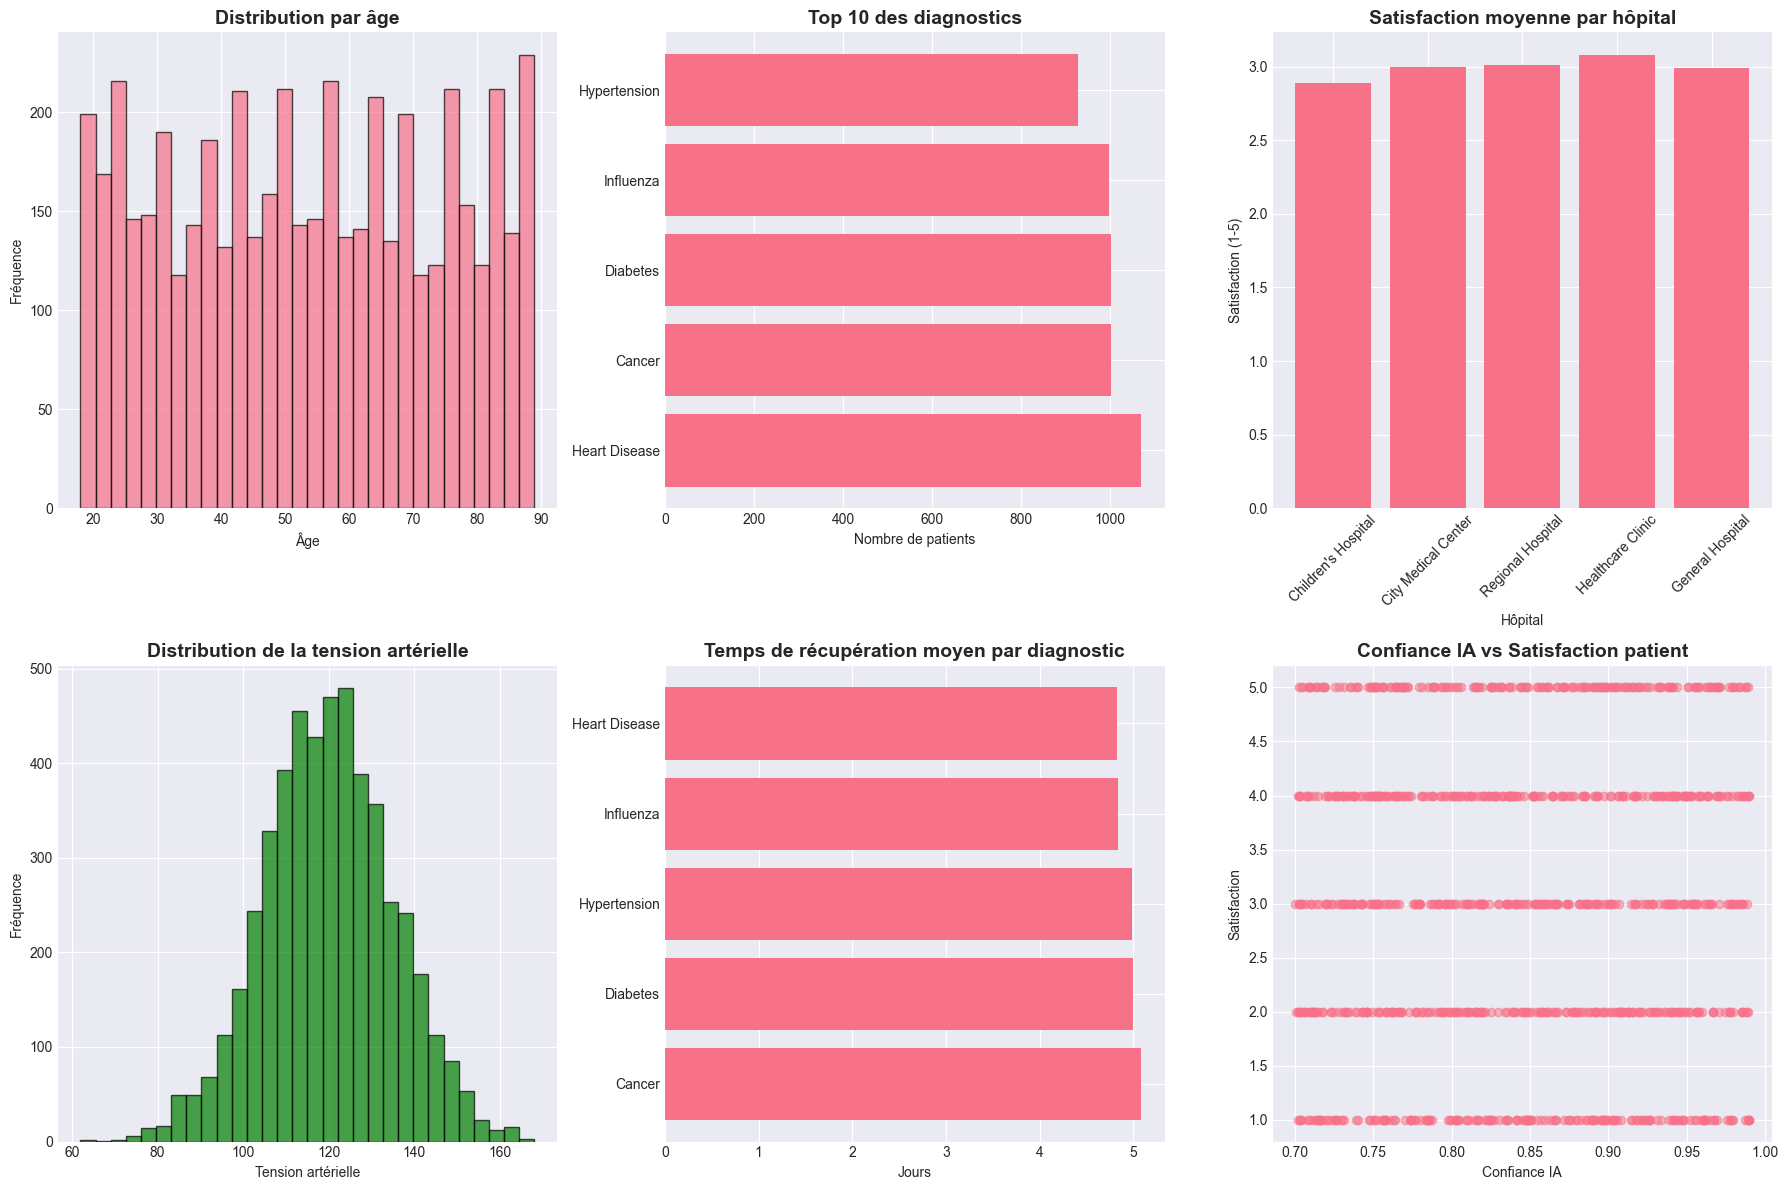

In [5]:

# %%
# 3. VISUALISATIONS

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribution par âge
with profiler.engine.connect() as conn:
    age_data = pd.read_sql("SELECT age FROM patients", conn)
    axes[0, 0].hist(age_data['age'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Distribution par âge', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Âge')
    axes[0, 0].set_ylabel('Fréquence')

# Diagnostics principaux
top_diagnoses = profile['diagnosis_distribution'].head(10)
axes[0, 1].barh(top_diagnoses['diagnosis_name'], top_diagnoses['patient_count'])
axes[0, 1].set_title('Top 10 des diagnostics', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Nombre de patients')

# Satisfaction par hôpital
hospital_perf = profile['hospital_performance'].head(10)
axes[0, 2].bar(hospital_perf['hospital_name'], hospital_perf['avg_satisfaction'])
axes[0, 2].set_title('Satisfaction moyenne par hôpital', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Hôpital')
axes[0, 2].set_ylabel('Satisfaction (1-5)')
axes[0, 2].tick_params(axis='x', rotation=45)

# Distribution de la tension artérielle
bp_data = pd.read_sql("SELECT blood_pressure FROM patients WHERE blood_pressure IS NOT NULL", profiler.engine)
axes[1, 0].hist(bp_data['blood_pressure'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title('Distribution de la tension artérielle', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Tension artérielle')
axes[1, 0].set_ylabel('Fréquence')

# Temps de récupération par diagnostic
recovery_data = pd.read_sql("""
    SELECT d.diagnosis_name, AVG(p.recovery_time) as avg_recovery
    FROM patients p
    JOIN diagnoses d ON p.diagnosis_id = d.diagnosis_id
    GROUP BY d.diagnosis_name
    ORDER BY avg_recovery DESC
    LIMIT 10
""", profiler.engine)
axes[1, 1].barh(recovery_data['diagnosis_name'], recovery_data['avg_recovery'])
axes[1, 1].set_title('Temps de récupération moyen par diagnostic', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Jours')

# Confiance IA vs Satisfaction
ai_satisfaction = pd.read_sql("""
    SELECT ai_diagnosis_confidence, patient_satisfaction 
    FROM patients 
    WHERE ai_diagnosis_confidence IS NOT NULL 
    AND patient_satisfaction IS NOT NULL
    LIMIT 1000
""", profiler.engine)
axes[1, 2].scatter(ai_satisfaction['ai_diagnosis_confidence'], 
                   ai_satisfaction['patient_satisfaction'], 
                   alpha=0.5)
axes[1, 2].set_title('Confiance IA vs Satisfaction patient', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Confiance IA')
axes[1, 2].set_ylabel('Satisfaction')

plt.tight_layout()
plt.show()



ANALYSE DES MÉDICAMENTS


,medication_name,prescriptions,avg_recovery_time,avg_satisfaction,avg_treatment_duration
0,Aspirin,1021,4.9,3.03,15.5
1,Antibiotics,1020,5.0,2.95,15.2
2,Chemotherapy,1017,5.0,2.98,14.5
3,Statins,980,4.9,3.03,14.5
4,Insulin,962,5.0,2.98,15.1


C:\Users\roosv\AppData\Local\Temp\ipykernel_35364\2532886833.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_meds, x='prescriptions', y='medication_name', palette='viridis')


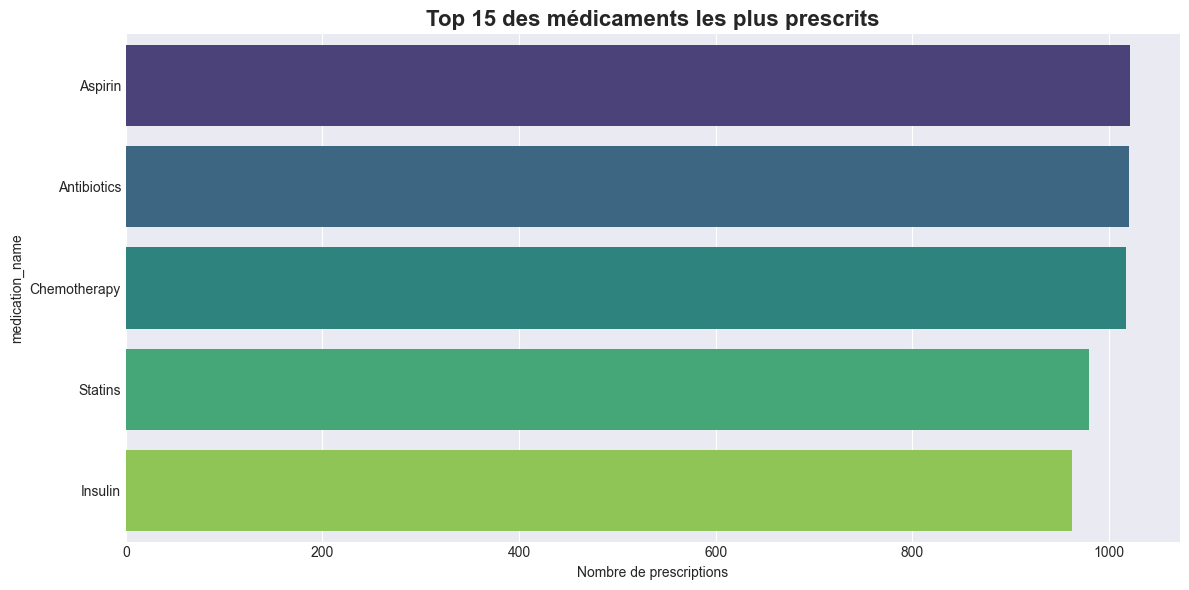

In [6]:

# %%
# 4. ANALYSE DES MÉDICAMENTS
print("\n" + "="*80)
print("ANALYSE DES MÉDICAMENTS")
print("="*80)

medications = profile['medication_effectiveness']
display(medications)

# Visualisation des médicaments les plus prescrits
plt.figure(figsize=(12, 6))
top_meds = medications.head(15)
sns.barplot(data=top_meds, x='prescriptions', y='medication_name', palette='viridis')
plt.title('Top 15 des médicaments les plus prescrits', fontsize=16, fontweight='bold')
plt.xlabel('Nombre de prescriptions')
plt.tight_layout()
plt.show()


In [7]:

# %%
# 5. ANALYSE DES ANOMALIES
print("\n" + "="*80)
print("DÉTECTION D'ANOMALIES")
print("="*80)

anomalies = report['anomalies']
print(f"Nombre d'anomalies détectées: {len(anomalies)}")
display(anomalies.head(10))



DÉTECTION D'ANOMALIES
Nombre d'anomalies détectées: 20


,patient_id,age,blood_pressure,heart_rate,age_zscore,bp_zscore,hr_zscore
0,208,52,73.00760,71.76856,0.068470,3.112187,0.299440
1,214,19,105.38233,44.27281,1.645029,0.961851,3.056043
2,596,68,135.70103,105.19052,0.695922,1.051924,3.051299
3,661,48,64.78993,82.94104,0.259568,3.658007,0.820664
4,734,67,116.86510,43.63142,0.648147,0.199162,3.120346
5,855,67,126.44883,108.28762,0.648147,0.437391,3.361800
6,1285,44,166.30844,63.94931,0.450666,3.084875,1.083364
7,1290,42,61.94012,75.59233,0.546215,3.847292,0.083914
8,1324,70,66.15982,59.90950,0.791471,3.567018,1.488377
9,1332,63,74.11763,68.40736,0.457049,3.038459,0.636419


In [8]:

# %%
# 6. CONCLUSIONS ET RECOMMANDATIONS
print("\n" + "="*80)
print("CONCLUSIONS ET RECOMMANDATIONS")
print("="*80)

completeness = report['completeness'].iloc[0]
consistency = report['consistency'].iloc[0]

print("\n▶ Forces:")
if completeness['age_completeness_pct'] > 99:
    print("  ✓ Excellente complétude des données démographiques")
if consistency['valid_age_pct'] > 99:
    print("  ✓ Très bonne cohérence des âges")

print("\n▶ Points d'amélioration:")
if completeness['satisfaction_completeness_pct'] < 100:
    print(f"  ○ {100 - completeness['satisfaction_completeness_pct']:.1f}% de données de satisfaction manquantes")
if len(anomalies) > 0:
    print(f"  ○ {len(anomalies)} anomalies statistiques détectées à investiguer")




CONCLUSIONS ET RECOMMANDATIONS

▶ Forces:
  ✓ Excellente complétude des données démographiques
  ✓ Très bonne cohérence des âges

▶ Points d'amélioration:
  ○ 20 anomalies statistiques détectées à investiguer
